In [19]:
import os
import warnings
warnings.filterwarnings("ignore")

import copy
from pathlib import Path
import warnings
import settings.settings as settings
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import numpy as np
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, RMSE, SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

## Data load

In [20]:
DATE_TRAIN_START = '2015-01-01'
DATE_VAL_END = '2023-06-17'
# DATE_VAL_END = '2023-05-07'
columns = ['AQI_PM25', 'month', 'weekday', 'year', 'tmin', 'Wx', 'Wy', 'prcp']
categories = ['month', 'weekday', ]

In [21]:
# CSV_JOINT_FILE = '../datasources/ds_joint/ds.csv'
# data_old = pd.read_csv(CSV_JOINT_FILE, parse_dates=True, index_col='DatetimeEnd')
# data_old = data_old[DATE_TRAIN_START:DATE_VAL_END]
# data_old.dtypes

In [22]:
# aqi_prev_years_file_path = "../../datasets/pollutants-enrich-data/aqi_enriched_prev_years.csv"
# aqi_cur_year_file_path= "../../datasets/pollutants-enrich-data/aqi_enriched_cur_year.csv"
# weather_prev_years_file_path = "../../datasets/weather-clean-data/weather_prev_years.csv"
# weather_cur_year_file_path = "../../datasets/weather-clean-data/weather_cur_year.csv"

In [23]:
# df_aqi_prev_years = pd.read_csv(aqi_prev_years_file_path,
#                                 index_col=settings.DATE_COLUMN_NAME,
#                                 parse_dates=True)
# df_aqi_cur_year = pd.read_csv(aqi_cur_year_file_path,
#                               index_col=settings.DATE_COLUMN_NAME,
#                               parse_dates=True)
# df_aqi = pd.concat([df_aqi_prev_years, df_aqi_cur_year])
# df_weather_prev_years = pd.read_csv(weather_prev_years_file_path,
#                                     index_col=settings.DATE_WEATHER_COLUMN_NAME,
#                                     parse_dates=True)
# df_weather_cur_year = pd.read_csv(weather_cur_year_file_path,
#                                   index_col=settings.DATE_WEATHER_COLUMN_NAME,
#                                   parse_dates=True)
# df_weather = pd.concat([df_weather_prev_years, df_weather_cur_year])
# data = df_weather.merge(df_aqi, how='left', left_index=True,
#                       right_index=True)
# data["AQI_PM25"] = data["AQI_PM25"].interpolate(method='time')
# data["year"].fillna(method='ffill', inplace=True)
# data["month"].fillna(method='ffill', inplace=True)
# data["weekday"] = (data["weekday"].fillna(method='ffill') + data["weekday"].fillna(method='bfill'))/2
#
# data = data[DATE_TRAIN_START:DATE_VAL_END]
# data = data[columns]
# data['Pollutant'] = '6001'
#
# date_column = settings.DATE_WEATHER_COLUMN_NAME
# # date_column = settings.DATE_COLUMN_NAME
# data.reset_index(inplace=True)
# data[settings.DATE_COLUMN_NUM_IND_NAME] = (data[date_column] - data[date_column].min()).dt.days
# data.drop(columns=[date_column], inplace=True)
# data["month"] = data["month"].astype(str).astype("category")
# data["weekday"] = data["weekday"].astype(str).astype("category")
#
# data.set_index(settings.DATE_COLUMN_NUM_IND_NAME, inplace=True)
# data.sort_index(inplace=True)
# data.reset_index(inplace=True)
# data.shape, data[settings.DATE_COLUMN_NUM_IND_NAME].min(), data[settings.DATE_COLUMN_NUM_IND_NAME].max()
# data

In [24]:
data = pd.read_csv("../../datasets/pollutants-weather-merged-data/aqi_all.csv", parse_dates=True,
                     index_col=settings.DATE_COLUMN_NAME)
data = data[DATE_TRAIN_START:DATE_VAL_END]
data = data[columns]
data['Pollutant'] = '6001'
data.reset_index(inplace=True)
data[settings.DATE_COLUMN_NUM_IND_NAME] = \
    (data[settings.DATE_COLUMN_NAME]
     - data[settings.DATE_COLUMN_NAME].min()).dt.days
# data.drop(columns=[settings.DATE_COLUMN_NAME], inplace=True)
# data.set_index(settings.DATE_COLUMN_NUM_IND_NAME, inplace=True)
# data.sort_index(inplace=True)
data["Pollutant"] = data["Pollutant"].astype(str).astype("category")
data["month"] = data["month"].astype(str).astype("category")
data["weekday"] = data["weekday"].astype(str).astype("category")
data["AQI_PM25"] = data["AQI_PM25"].astype(float)
# data.reset_index(inplace=True)
data

,DatetimeEnd,AQI_PM25,month,weekday,year,tmin,Wx,Wy,prcp,Pollutant,date_idx
0,2015-01-01,128.0,1,3,2015,0.00,0.000000,0.000000,0.0,6001,0
1,2015-01-02,46.0,1,4,2015,5.00,-7.572155,-30.370256,0.0,6001,1
2,2015-01-03,46.0,1,5,2015,2.90,0.000000,0.000000,0.0,6001,2
3,2015-01-04,32.0,1,6,2015,1.95,0.000000,0.000000,0.0,6001,3
4,2015-01-05,80.0,1,0,2015,1.00,-13.265411,-3.803796,0.0,6001,4
...,...,...,...,...,...,...,...,...,...,...,...
3085,2023-06-13,23.0,6,1,2023,15.40,7.580184,17.857794,0.0,6001,3085
3086,2023-06-14,14.0,6,2,2023,13.40,5.900040,13.899623,0.0,6001,3086
3087,2023-06-15,15.0,6,3,2023,14.30,9.957645,4.433429,0.0,6001,3087
3088,2023-06-16,22.0,6,4,2023,13.30,8.219225,1.155137,0.0,6001,3088


In [25]:
data.isna().sum()

DatetimeEnd    0
AQI_PM25       0
month          0
weekday        0
year           0
tmin           0
Wx             0
Wy             0
prcp           0
Pollutant      0
date_idx       0
dtype: int64

## TimeSeriesDataset creation

In [26]:
max_prediction_length = 7
max_encoder_length = 28
training_cutoff = data[settings.DATE_COLUMN_NUM_IND_NAME].max() - max_prediction_length

training = TimeSeriesDataSet(
    data[lambda x: x[settings.DATE_COLUMN_NUM_IND_NAME] <= training_cutoff],
    time_idx=settings.DATE_COLUMN_NUM_IND_NAME,
    target="AQI_PM25",
    group_ids=["Pollutant"],
    min_encoder_length=max_encoder_length // 2,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,      # lookback period
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # static_categoricals=["agency", "sku"],
    static_reals=["year"],
    time_varying_known_categoricals=["month", "weekday"],
    time_varying_known_reals=[settings.DATE_COLUMN_NUM_IND_NAME, "tmin", "Wx", "Wy", "prcp"],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=[],
    target_normalizer=GroupNormalizer(
        groups=["Pollutant"], transformation="softplus"
    ),  # use softplus and normalize by group
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    #allow_missing_timesteps =True
)

# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, data, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 128  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size * 10, num_workers=0)

## Base model

In [27]:
# calculate baseline mean absolute error, i.e. predict next value as the last available value from the history
baseline_predictions = Baseline().predict(val_dataloader, return_y=True)
RMSE()(baseline_predictions.output, baseline_predictions.y)

tensor(8.2462)

In [28]:
baseline_predictions

Prediction(output=tensor([[27., 27., 27., 27., 27., 27., 27.]]), x=None, index=None, decoder_lengths=None, y=(tensor([[34., 19., 23., 14., 15., 22., 30.]]), None))

## Temporal Fusion Transformer training

### Optimal learning rate

In [29]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
)


tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    loss=QuantileLoss(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 10.9k


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.17782794100389226
Restoring states from the checkpoint path at /home/alexandra/work/projects/air_pol/air_pollution_predict/airpollpredictor/jupiter_experiments/pytorch_forecasting/.lr_find_27bb8984-a6a7-48ed-abd9-e12dba770fea.ckpt
Restored all states from the checkpoint at /home/alexandra/work/projects/air_pol/air_pollution_predict/airpollpredictor/jupiter_experiments/pytorch_forecasting/.lr_find_27bb8984-a6a7-48ed-abd9-e12dba770fea.ckpt


suggested learning rate: 0.17782794100389226


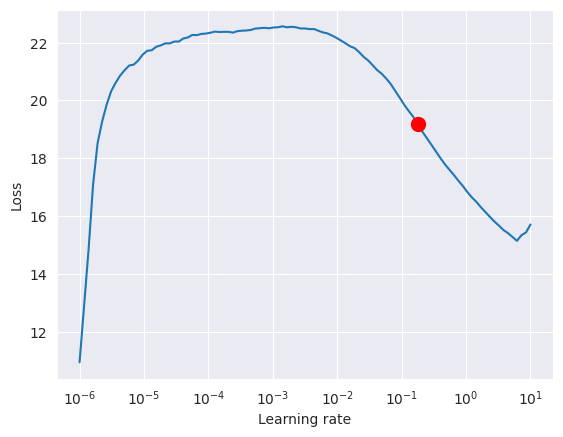

In [12]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=100` reached.
Learning rate set to 0.33884415613920277
Restoring states from the checkpoint path at /home/alexandra/work/projects/air_pol/air_pollution_predict/airpollpredictor/jupiter_experiments/pytorch_forecasting/.lr_find_97b9499e-37c0-47da-8640-c6a10011ff60.ckpt
Restored all states from the checkpoint at /home/alexandra/work/projects/air_pol/air_pollution_predict/airpollpredictor/jupiter_experiments/pytorch_forecasting/.lr_find_97b9499e-37c0-47da-8640-c6a10011ff60.ckpt


suggested learning rate: 0.33884415613920277


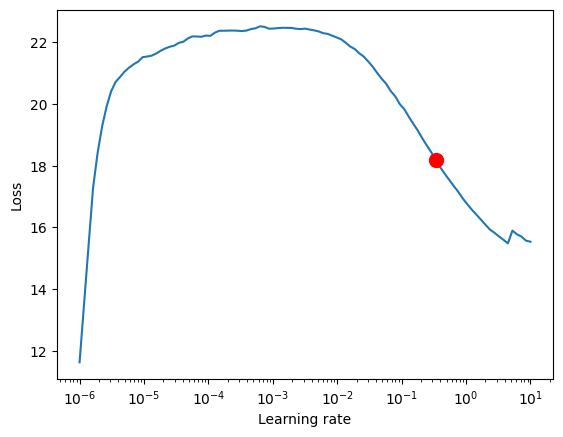

In [76]:
# find optimal learning rate
from lightning.pytorch.tuner import Tuner

res = Tuner(trainer).lr_find(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
    max_lr=10.0,
    min_lr=1e-6,
)

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

### Model training

In [77]:
import tensorflow as tf
import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [30]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.1,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.1,
    hidden_size=16,
    attention_head_size=2,
    dropout=0.1,
    hidden_continuous_size=8,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 24.6k


In [31]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)
# RMSE = 7,968 for lr = 0.1


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 107   
3  | prescalers                         | ModuleDict                      | 160   
4  | static_variable_selection          | VariableSelectionNetwork        | 2.3 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 4.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.1 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 1.1 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 1.1 

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [80]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [32]:
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
RMSE()(predictions.output, predictions.y).item()

17.044940948486328

In [82]:
v = RMSE()(predictions.output, predictions.y)
v.item()

17.044940948486328

In [31]:
predictions._asdict()

{'output': tensor([[32.7093, 34.4104, 32.7111, 35.4574, 30.5608, 34.4707, 35.9845]]),
 'x': None,
 'index': None,
 'decoder_lengths': None,
 'y': (tensor([[34., 19., 23., 14., 15., 22., 30.]]), None)}

In [44]:
pd.DataFrame(predictions.output[0], columns=['C1'])

,C1
0,32.709255
1,34.410378
2,32.711063
3,35.457352
4,30.560772
5,34.470715
6,35.984535


In [50]:
import shutil, zipfile, os

In [19]:
best_model_path

'lightning_logs/lightning_logs/version_3/checkpoints/epoch=27-step=1288.ckpt'

In [53]:
name = best_model_path[:best_model_path.rindex('/checkpoints')]
zip_name = '"../../experiments_results/tft/6001/model.zip'

with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zip_ref:
    for folder_name, subfolders, filenames in os.walk(name):
        for filename in filenames:
            file_path = os.path.join(folder_name, filename)
            zip_ref.write(file_path, arcname=os.path.relpath(file_path, name))
zip_ref.close()

# archive = shutil.make_archive(model_folder, 'zip', "model.zip")
# dst = "../../experiments_results/tft/6001/model.zip"
# shutil.copyfile(archive, dst)

In [54]:
dst = "../../experiments_results/tft/6001/model.ckpt"
shutil.copyfile(best_model_path, dst)

In [21]:
best_tft_ss = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
predictions = best_tft_ss.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
RMSE()(predictions.output, predictions.y)

tensor(7.9680)

In [16]:
best_model_path

'lightning_logs/lightning_logs/version_3/checkpoints/epoch=27-step=1288.ckpt'

### Features importance

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x300 with 1 Axes>,
 'encoder_variables': <Figure size 700x400 with 1 Axes>,
 'decoder_variables': <Figure size 700x400 with 1 Axes>}

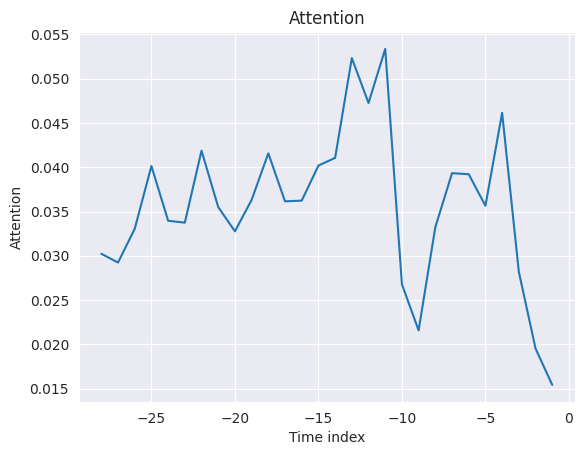

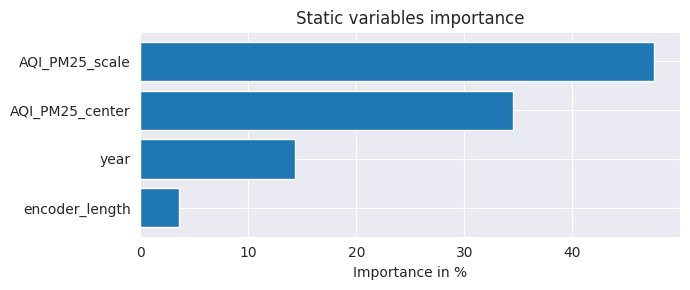

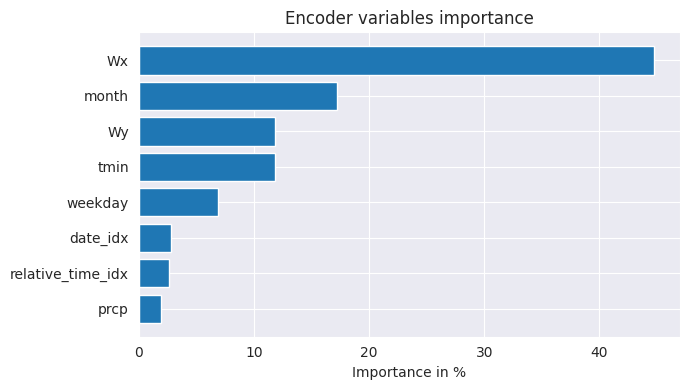

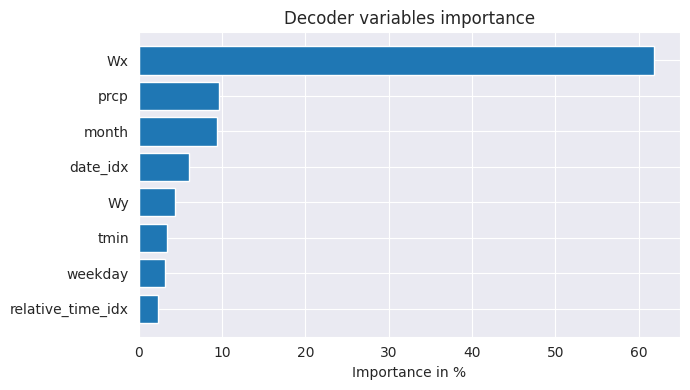

In [33]:
pred = best_tft.predict(val_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))
# x_pred =  pred.output[0]
interpretation = best_tft.interpret_output(pred.output, reduction="sum")
best_tft.plot_interpretation(interpretation)
# pred.output.decoder_attention

### Extreme events detection

{'year': <Figure size 1000x500 with 2 Axes>,
 'encoder_length': <Figure size 1000x500 with 2 Axes>,
 'AQI_PM25_center': <Figure size 1000x500 with 2 Axes>,
 'AQI_PM25_scale': <Figure size 1000x500 with 2 Axes>,
 'date_idx': <Figure size 1000x500 with 2 Axes>,
 'tmin': <Figure size 1000x500 with 2 Axes>,
 'Wx': <Figure size 1000x500 with 2 Axes>,
 'Wy': <Figure size 1000x500 with 2 Axes>,
 'prcp': <Figure size 1000x500 with 2 Axes>,
 'relative_time_idx': <Figure size 1000x500 with 2 Axes>,
 'month': <Figure size 1000x500 with 2 Axes>,
 'weekday': <Figure size 640x480 with 2 Axes>}

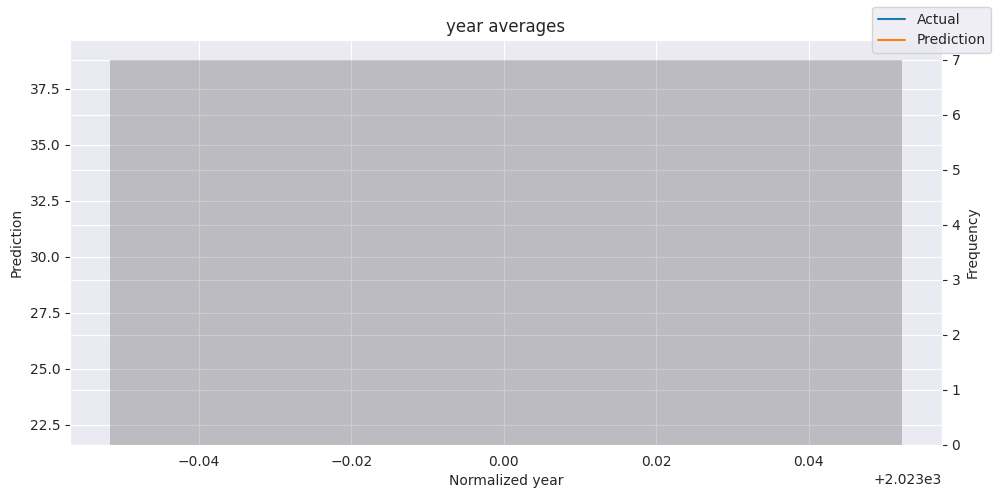

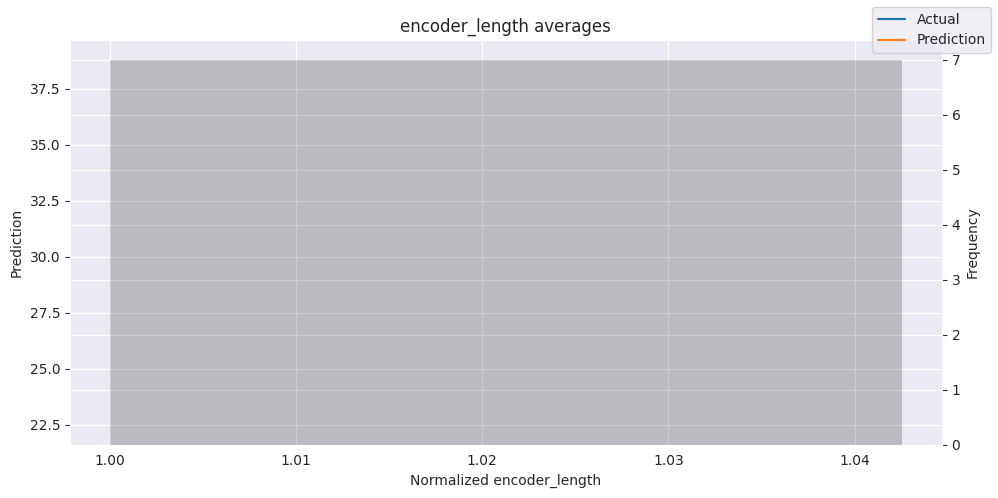

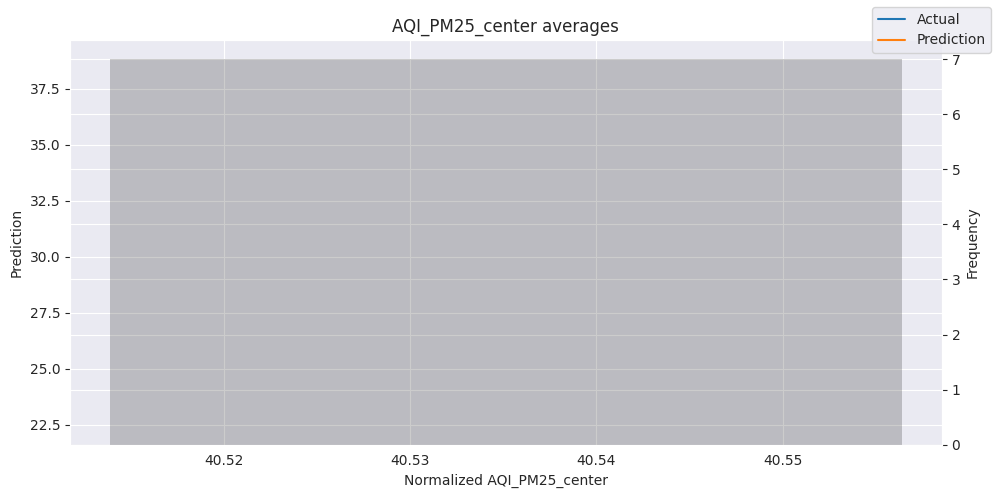

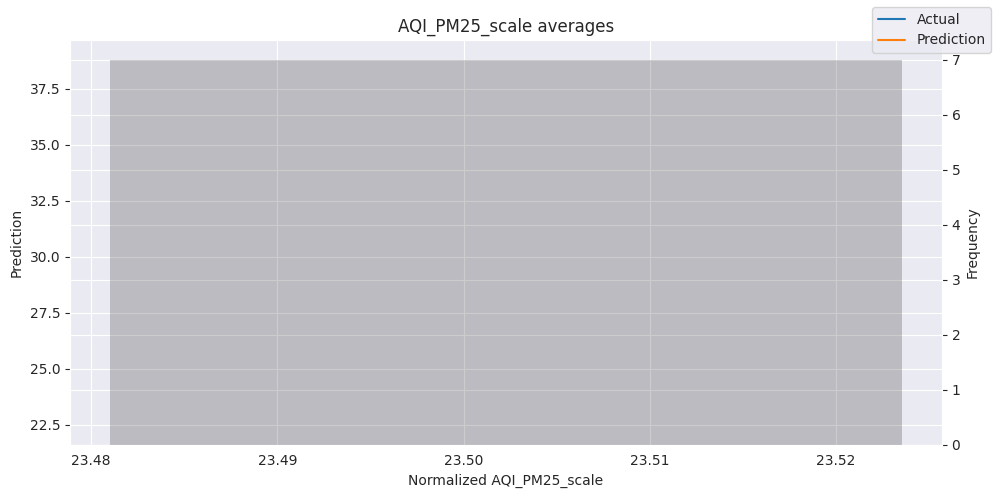

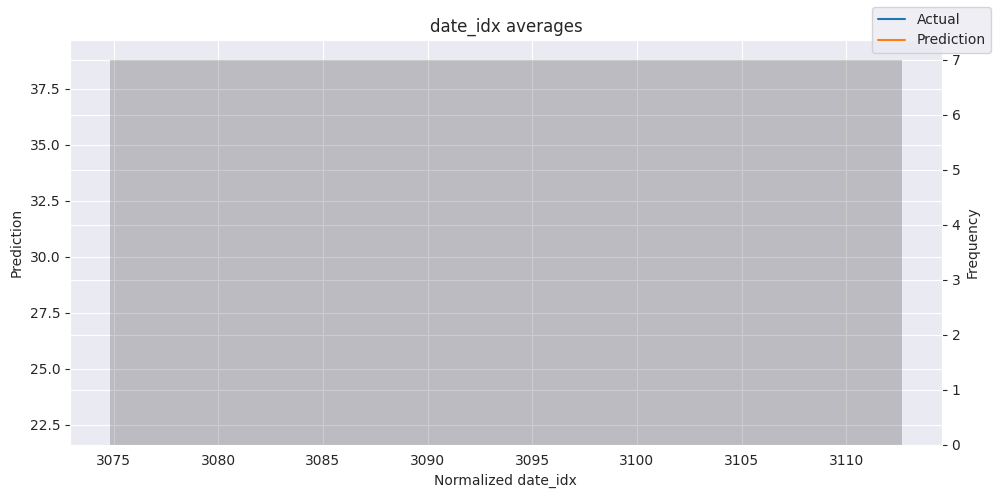

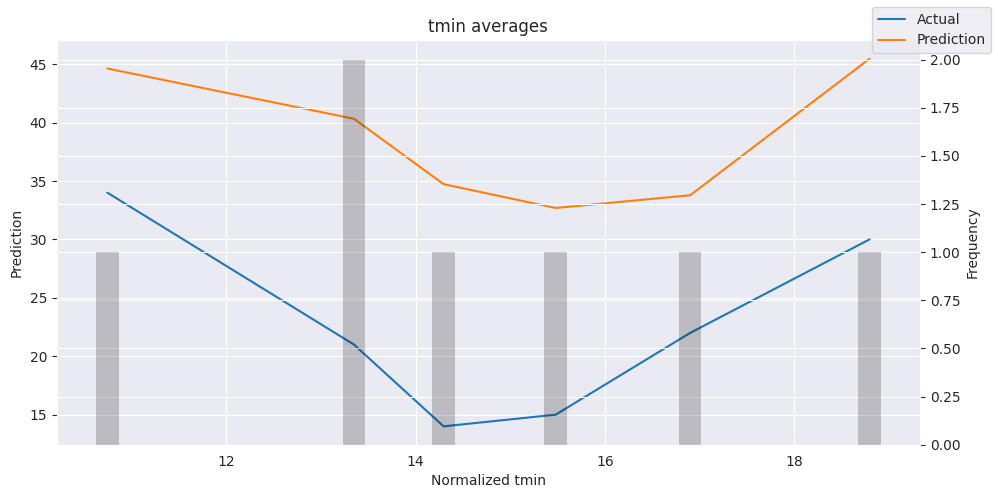

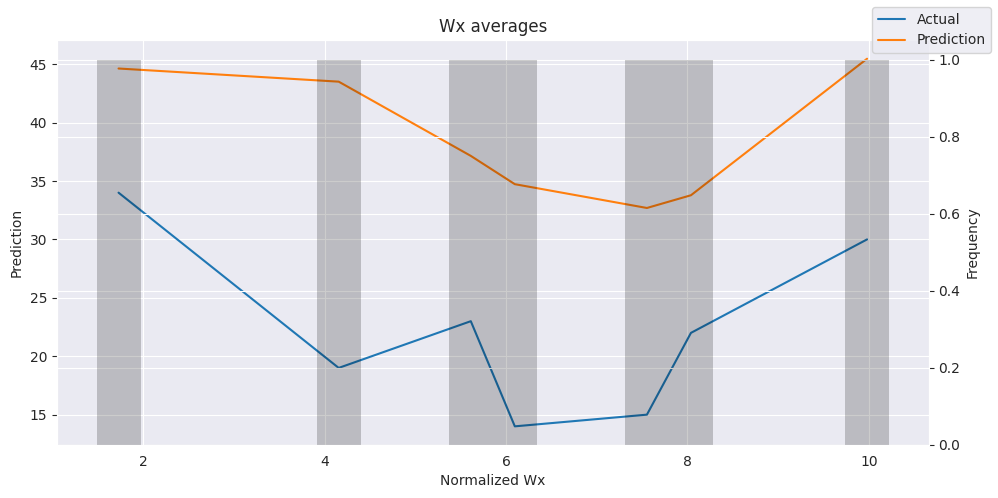

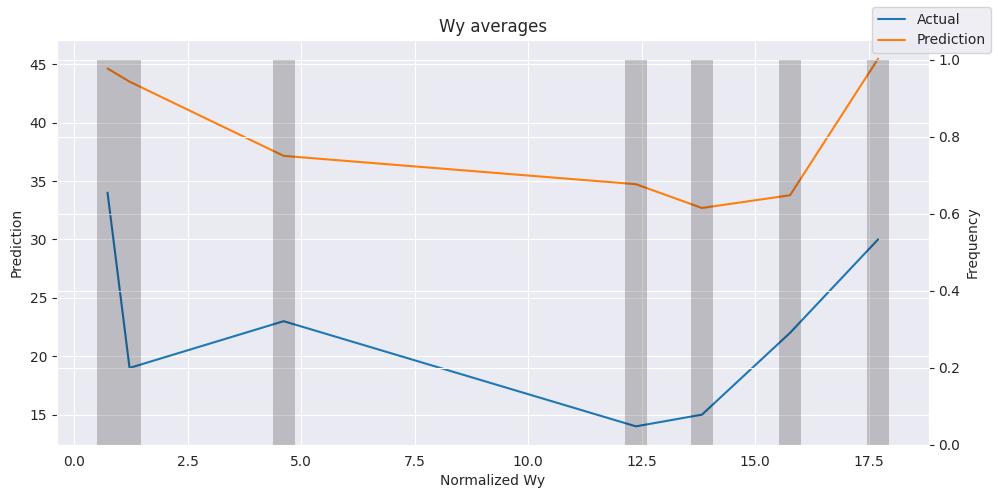

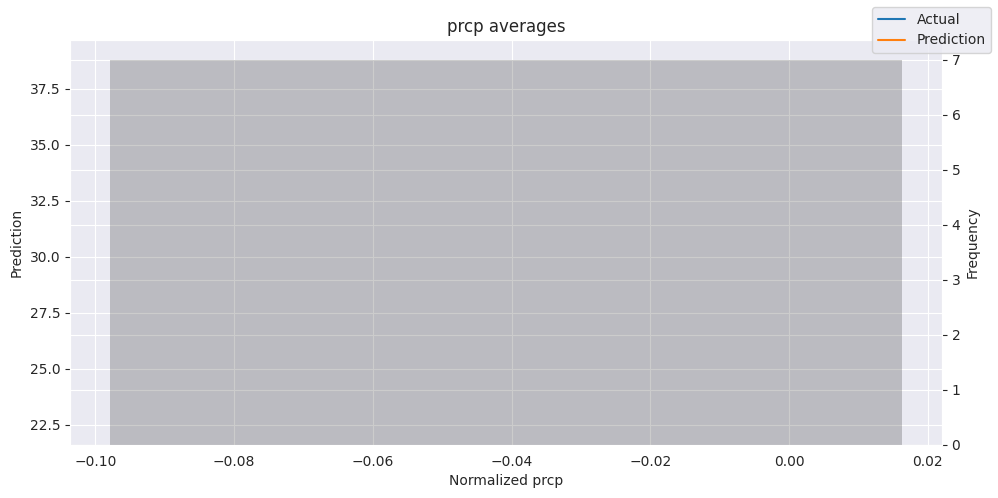

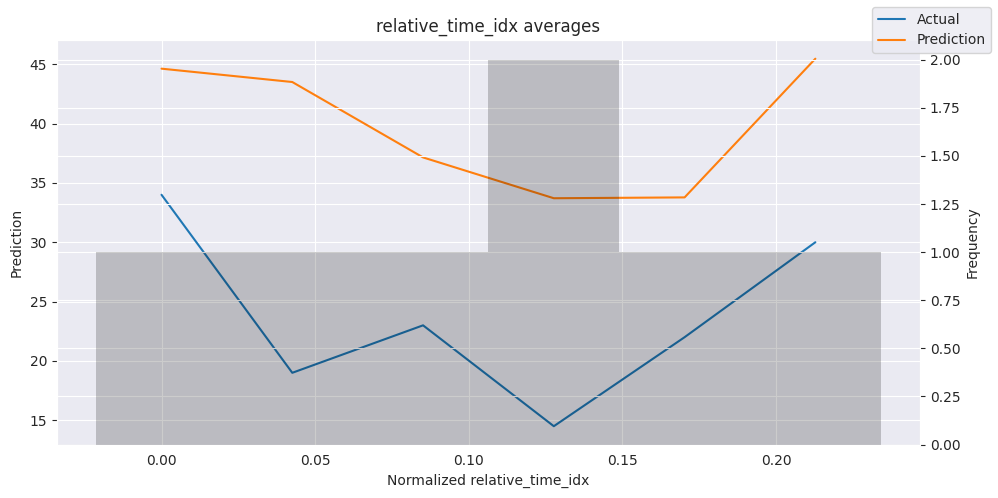

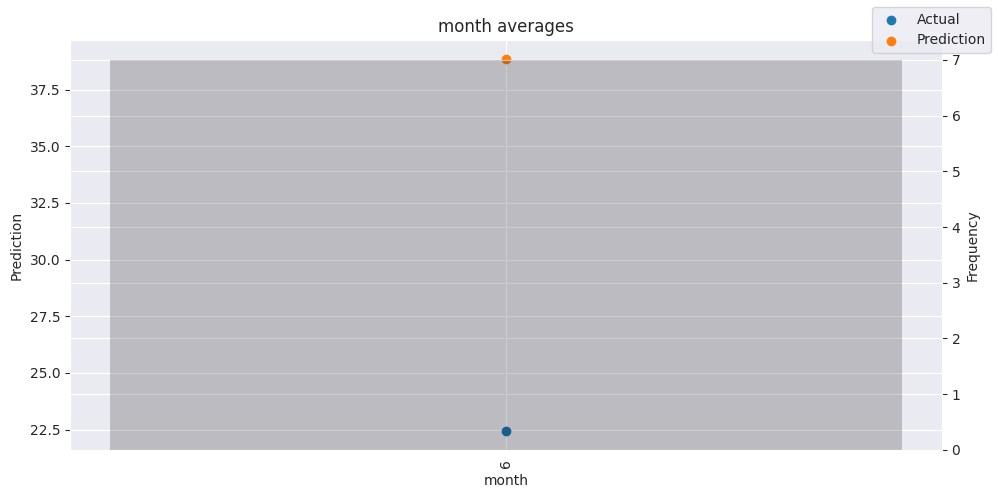

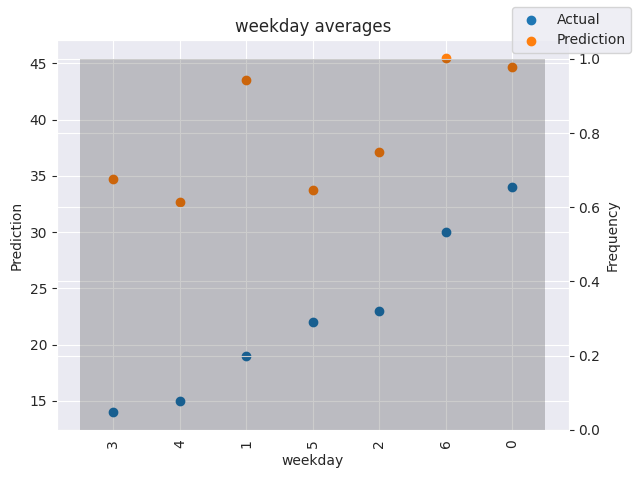

In [34]:
pred = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(pred.x, pred.output)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals)

## Hyperparameter tuning

In [ ]:
import pickle

from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

# create study
study = optimize_hyperparameters(
    train_dataloader,
    val_dataloader,
    model_path="optuna_test",
    n_trials=10,
    max_epochs=50,
    gradient_clip_val_range=(0.01, 1.0),
    hidden_size_range=(8, 128),
    hidden_continuous_size_range=(8, 128),
    attention_head_size_range=(1, 4),
    learning_rate_range=(0.01, 0.1),
    dropout_range=(0.1, 0.3),
    trainer_kwargs=dict(limit_train_batches=30),
    reduce_on_plateau_patience=4,
    use_learning_rate_finder=False,  # use Optuna to find ideal learning rate or use in-built learning rate finder
)

# save study results - also we can resume tuning at a later point in time
with open("test_study.pkl", "wb") as fout:
    pickle.dump(study, fout)

# show best hyperparameters
print(study.best_trial.params)

## Evaluate performance

In [ ]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")  # logging results to a tensorboard

trainer = pl.Trainer(
    max_epochs=50,
    accelerator="cpu",
    enable_model_summary=True,
    gradient_clip_val=0.02585843587541623,
    limit_train_batches=50,  # coment in for training, running valiation every 30 batches
    # fast_dev_run=True,  # comment in to check that networkor dataset has no serious bugs
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.26194034712066407,
    hidden_size=28,
    attention_head_size=3,
    dropout=0.21424545981175253,
    hidden_continuous_size=25,
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    optimizer="Ranger",
    reduce_on_plateau_patience=4,
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

In [ ]:
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)
# calcualte mean absolute error on validation set
predictions = best_tft.predict(val_dataloader, return_y=True, trainer_kwargs=dict(accelerator="cpu"))
RMSE()(predictions.output, predictions.y)

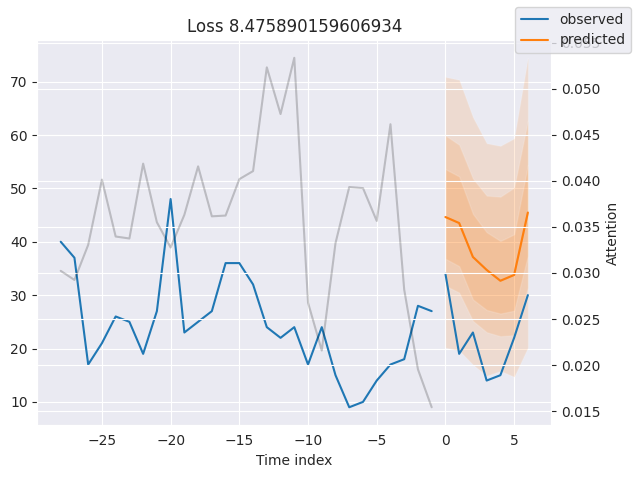

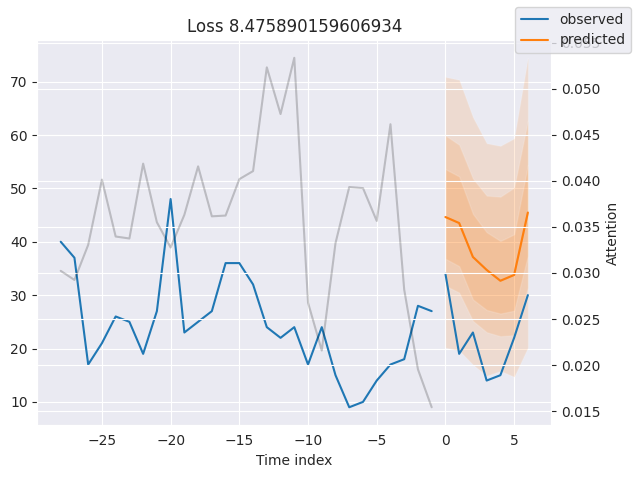

In [35]:
# raw predictions are a dictionary from which all kind of information including quantiles can be extracted
raw_predictions = best_tft.predict(val_dataloader, mode="raw", return_x=True)
best_tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=0, add_loss_to_title=True)